In [730]:
import yfinance as yf
import pandas as pd
import os

# symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "AMZN"]
symbols = ["AAPL"]



# Define the stock symbol and the time period
symbol = "AAPL"
start_date = "2015-11-1"  
end_date = "2025-10-31"

# Fetch historical data
filename = f"{symbol}_{start_date}_to_{end_date}.csv"
if os.path.exists(filename):
    print("CSV exists, skipping download:", filename)
else:
    data = yf.download(symbol, start=start_date, end=end_date)
    data.to_csv(filename)
    print("Saved CSV:", filename)

# load CSV back into `data`
data = pd.read_csv(filename, index_col=0, parse_dates=True)
print("Loaded CSV:", filename, "rows:", len(data))
# show data head

# change Price to Date and remove second and third rows
data = data.iloc[2:]
data = data.reset_index().rename(columns={"Price": "Date"})
data.head()
data = data.drop(columns=["Open", "High", "Low", "Volume"])


CSV exists, skipping download: AAPL_2015-11-1_to_2025-10-31.csv
Loaded CSV: AAPL_2015-11-1_to_2025-10-31.csv rows: 2516


C:\Users\Lau\AppData\Local\Temp\ipykernel_34772\1836253107.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filename, index_col=0, parse_dates=True)


In [731]:

WINDOW = 7
FUTURE = 20
data_ma = data.copy()
data_ma['MA'] = data['Close'].rolling(window=WINDOW).mean()

# set first rows in window to first value 
first = data_ma['Close'].iloc[0]
# ensure numeric dtype then assign using .loc to avoid chained assignment
data_ma['Close'] = pd.to_numeric(data_ma['Close'], errors='coerce')
data_ma['MA'] = pd.to_numeric(data_ma['MA'], errors='coerce')
# offset MA by FUTURE days
data_ma['MA'] = data_ma['MA'].shift(-FUTURE)
first_val = float(data_ma['Close'].iat[0])
last_val = float(data_ma['MA'].iat[WINDOW + FUTURE -1])
increment = (last_val - first_val) / (WINDOW + FUTURE -1)
for i in range(WINDOW + FUTURE -1):
    # gradually increase from first to the value at index WINDOW + FUTURE -1
    data_ma.at[i, 'MA'] = first_val + increment * i

# percentage change of MA compared to previous row, max is 0
data_ma['MADROP'] = data_ma['MA'].pct_change().clip(upper=0)
# set first value of MADROP to second value
data_ma.at[0, 'MADROP'] = data_ma.at[1, 'MADROP']
data_ma.drop(columns=['Close','MA'], inplace=True)
data_ma.shape

C:\Users\Lau\AppData\Local\Temp\ipykernel_34772\2188784274.py:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data_ma['MADROP'] = data_ma['MA'].pct_change().clip(upper=0)


(2514, 2)

In [732]:

# import lstm_price_diff_export.csv
lstm_diff = pd.read_csv('lstm_price_diff_export.csv', parse_dates=['Date'])

# Ensure both Date columns are datetime64[ns] and normalized (remove time / tz differences)
data_ma['Date'] = pd.to_datetime(data_ma['Date'], errors='coerce').dt.normalize()
lstm_diff['Date'] = pd.to_datetime(lstm_diff['Date'], errors='coerce').dt.normalize()

# Drop rows with unparseable dates (if any)
data_ma = data_ma.dropna(subset=['Date'])
lstm_diff = lstm_diff.dropna(subset=['Date'])

# Now merge
data_final = pd.merge(data_ma, lstm_diff, on='Date', how='inner')
print(f"data_final shape: {data_final.shape}")
data_final[-10:]


data_final shape: (2441, 3)


,Date,MADROP,LSTMDIFF
2431,2025-10-17,0.0,10.280649
2432,2025-10-20,0.0,14.492605
2433,2025-10-21,0.0,14.838834
2434,2025-10-22,0.0,12.330786
2435,2025-10-23,0.0,12.734640
2436,2025-10-24,0.0,14.250699
2437,2025-10-27,0.0,16.501640
2438,2025-10-28,0.0,16.318043
2439,2025-10-29,0.0,17.501186
2440,2025-10-30,0.0,21.405582


In [733]:
# import sentiment_ma_drop.csv
data_spy = pd.read_csv('sentiment_ma_drop.csv', parse_dates=['Date'])
data_spy['Date'] = pd.to_datetime(data_spy['Date'], errors='coerce').dt.normalize()
data_spy = data_spy.dropna(subset=['Date'])
print(data_spy.shape)


data_final = pd.merge(data_final, data_spy, on='Date', how='inner')
print(f"data_final shape after sentiment merge: {data_final.shape}")
print(data_final[:10])
print(data_final[-10:])

(2514, 2)
data_final shape after sentiment merge: (2441, 4)
        Date    MADROP   LSTMDIFF  SENTIMENT
0 2016-02-18  0.000000 -13.336493  -0.001354
1 2016-02-19  0.000000 -15.751677  -0.001787
2 2016-02-22  0.000000 -12.847323  -0.000570
3 2016-02-23  0.000000 -11.521905  -0.001273
4 2016-02-24  0.000000  -7.373272  -0.001493
5 2016-02-25  0.000000  -5.348763  -0.000861
6 2016-02-26 -0.001051  -5.191723  -0.003048
7 2016-02-29  0.000000  -8.542693  -0.001216
8 2016-03-01  0.000000  -7.180503  -0.000246
9 2016-03-02  0.000000  -5.862369  -0.000770
           Date  MADROP   LSTMDIFF  SENTIMENT
2431 2025-10-17     0.0  10.280649  -0.002416
2432 2025-10-20     0.0  14.492605  -0.001316
2433 2025-10-21     0.0  14.838834  -0.001848
2434 2025-10-22     0.0  12.330786  -0.002042
2435 2025-10-23     0.0  12.734640  -0.001619
2436 2025-10-24     0.0  14.250699  -0.001505
2437 2025-10-27     0.0  16.501640  -0.001325
2438 2025-10-28     0.0  16.318043  -0.001637
2439 2025-10-29     0.0  17.501

In [734]:
# import fundamental_zscore.csv
fundamental_zscore = pd.read_csv('fundamental_zscore.csv', parse_dates=['Date'])
fundamental_zscore['Date'] = pd.to_datetime(fundamental_zscore['Date'], errors='coerce').dt.normalize()
fundamental_zscore = fundamental_zscore.dropna(subset=['Date'])
fundamental_zscore

,Date,ZSCORE
0,2025-09-30,10.741872
1,2024-09-30,9.891161
2,2023-09-30,10.482106
3,2022-09-30,10.170596


In [735]:

# check min start date

if not fundamental_zscore.empty:
    min_date = fundamental_zscore['Date'].min()
    print(f"Fundamental zscore min date: {min_date}")
    # check if min_date < data_final min date
    data_final_min_date = data_final['Date'].min()
    if min_date > data_final_min_date:
        # fill missing dates between row in fundamental_zscore, the value is the previous row value
        all_dates = pd.date_range(start=min_date, end=data_final['Date'].max(), freq='D')
        fundamental_zscore = fundamental_zscore.set_index('Date').reindex(all_dates).ffill().reset_index().rename(columns={'index': 'Date'})
        print(f"Fundamental zscore after reindex shape: {fundamental_zscore.shape}")
        
        

data_final = pd.merge(data_final, fundamental_zscore, on='Date', how='inner')
print(f"data_final shape after fundamental merge: {data_final.shape}")
# show unique z_score
print("Unique z_score values:", data_final['ZSCORE'].unique())
print(data_final[:5])
print(data_final[-5:])

Fundamental zscore min date: 2022-09-30 00:00:00
Fundamental zscore after reindex shape: (1127, 2)
data_final shape after fundamental merge: (774, 5)
Unique z_score values: [10.1705958  10.48210648  9.89116123 10.74187198]
        Date    MADROP   LSTMDIFF  SENTIMENT     ZSCORE
0 2022-09-30  0.000000 -13.546838  -0.001586  10.170596
1 2022-10-03  0.000000  -7.699440  -0.001168  10.170596
2 2022-10-04  0.000000  -5.505587  -0.001421  10.170596
3 2022-10-05 -0.004187  -4.229241  -0.001976  10.170596
4 2022-10-06 -0.012804  -2.092993  -0.001614  10.170596
          Date  MADROP   LSTMDIFF  SENTIMENT     ZSCORE
769 2025-10-24     0.0  14.250699  -0.001505  10.741872
770 2025-10-27     0.0  16.501640  -0.001325  10.741872
771 2025-10-28     0.0  16.318043  -0.001637  10.741872
772 2025-10-29     0.0  17.501186  -0.001611  10.741872
773 2025-10-30     0.0  21.405582  -0.001658  10.741872


In [736]:
# pytorch 3 features, 1 target model, single linear layer, nolstm
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

model = SimpleNN(input_size=3, hidden_size=8, output_size=1)
print(model)


SimpleNN(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [737]:
# train final model
import numpy as np
from sklearn.model_selection import train_test_split    
# Prepare data
features = data_final[['LSTMDIFF', 'SENTIMENT', 'ZSCORE']].values
targets = data_final['MADROP'].values
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [738]:
# Training with Adam optimizer and linear LR schedule from initial_lr -> final_lr
criterion = nn.MSELoss()
initial_lr = 0.01
# final_lr = 0.00005

# use Adam instead of SGD
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# total epochs (keep existing value)
num_epochs = 20000

# Lambda that linearly scales lr from 1.0 -> final_ratio
# final_ratio = final_lr / initial_lr
# def lr_lambda(epoch):
#     if num_epochs <= 1:
#         return final_ratio
#     return 1.0 - (epoch / (num_epochs - 1)) * (1.0 - final_ratio)

# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    # scheduler.step()
    if (epoch + 1) % 100 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.10f}, LR: {lr:.8f}')


Epoch [100/20000], Loss: 0.0029786369, LR: 0.01000000
Epoch [200/20000], Loss: 0.0020224464, LR: 0.01000000
Epoch [300/20000], Loss: 0.0011402293, LR: 0.01000000
Epoch [400/20000], Loss: 0.0006290533, LR: 0.01000000
Epoch [500/20000], Loss: 0.0003014262, LR: 0.01000000
Epoch [600/20000], Loss: 0.0001465651, LR: 0.01000000
Epoch [700/20000], Loss: 0.0000910112, LR: 0.01000000
Epoch [800/20000], Loss: 0.0000688552, LR: 0.01000000
Epoch [900/20000], Loss: 0.0000525827, LR: 0.01000000
Epoch [1000/20000], Loss: 0.0000452925, LR: 0.01000000
Epoch [1100/20000], Loss: 0.0000412394, LR: 0.01000000
Epoch [1200/20000], Loss: 0.0000388106, LR: 0.01000000
Epoch [1300/20000], Loss: 0.0000367401, LR: 0.01000000
Epoch [1400/20000], Loss: 0.0000349195, LR: 0.01000000
Epoch [1500/20000], Loss: 0.0000332636, LR: 0.01000000
Epoch [1600/20000], Loss: 0.0000317189, LR: 0.01000000
Epoch [1700/20000], Loss: 0.0000302576, LR: 0.01000000
Epoch [1800/20000], Loss: 0.0000288664, LR: 0.01000000
Epoch [1900/20000],

In [739]:
# export model
model_filename = 'model_final.pth'
torch.save(model.state_dict(), model_filename)

In [740]:
# import model

model.load_state_dict(torch.load(model_filename))
# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.10f}')
# Final predictions
with torch.no_grad():
    final_predictions = model(torch.tensor(features, dtype=torch.float32)).numpy()
data_final['PREDICTION'] = final_predictions
data_final[-10:]

Test Loss: 0.0000196006


,Date,MADROP,LSTMDIFF,SENTIMENT,ZSCORE,PREDICTION
764,2025-10-17,0.0,10.280649,-0.002416,10.741872,-0.000304
765,2025-10-20,0.0,14.492605,-0.001316,10.741872,-0.000572
766,2025-10-21,0.0,14.838834,-0.001848,10.741872,-0.000985
767,2025-10-22,0.0,12.330786,-0.002042,10.741872,-0.000343
768,2025-10-23,0.0,12.734640,-0.001619,10.741872,-0.000305
769,2025-10-24,0.0,14.250699,-0.001505,10.741872,-0.000543
770,2025-10-27,0.0,16.501640,-0.001325,10.741872,-0.001669
771,2025-10-28,0.0,16.318043,-0.001637,10.741872,-0.001671
772,2025-10-29,0.0,17.501186,-0.001611,10.741872,-0.001440
773,2025-10-30,0.0,21.405582,-0.001658,10.741872,-0.000665


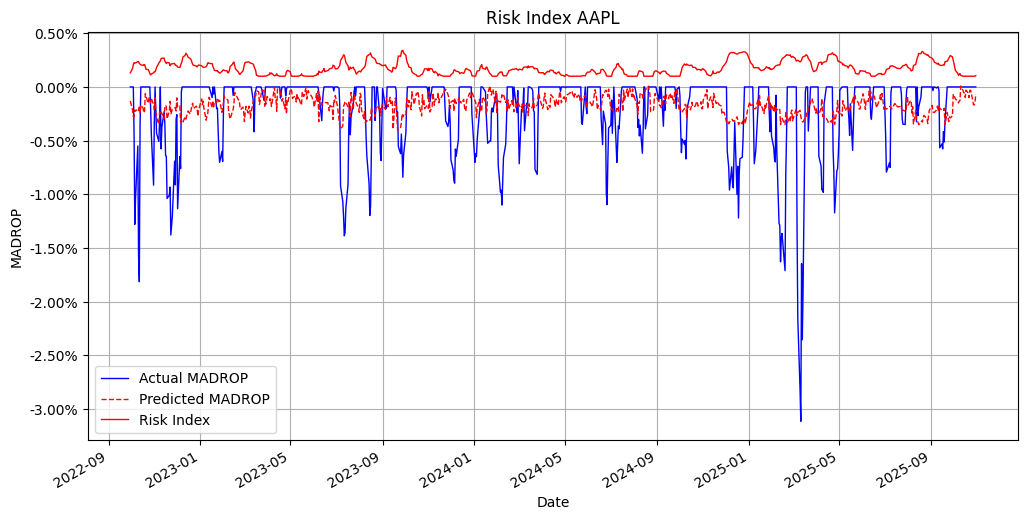

In [746]:
# visualize pred and actual using ax and percent formatting
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# final adjusted index

OFFSET = 0.001
RISK_WINDOW = 5
# risk_index = avg ( 4 previous pred + current pred) , OFFSET
risk_index = data_final['PREDICTION'].copy()
for i in range(len(risk_index)):
    if i < RISK_WINDOW:
        risk_index.iat[i] = data_final['PREDICTION'].iloc[:i+1].mean() * -1
    else:
        risk_index.iat[i] = data_final['PREDICTION'].iloc[i-RISK_WINDOW:i+1].mean() * -1
    
    if risk_index.iat[i] < OFFSET:
        risk_index.iat[i] = OFFSET

fig, ax = plt.subplots(figsize=(12,6))
data_final['Date'] = pd.to_datetime(data_final['Date'])
ax.plot(data_final['Date'], data_final['MADROP'], label='Actual MADROP', color='blue', linewidth=1)
ax.plot(data_final['Date'], data_final['PREDICTION'], label='Predicted MADROP', color='red', linestyle='--', linewidth=1)
ax.plot(data_final['Date'], risk_index, label='Risk Index', color='red', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('MADROP')
ax.set_title('Risk Index AAPL')
ax.legend()
ax.grid(True)
# format y-axis as percent (assumes values are fractions, e.g. -0.002 -> -0.20%)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, pos: f"{y*100:.2f}%"))
fig.autofmt_xdate()
plt.show()